In [2]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip "/content/drive/MyDrive/testsetandtrainingset.zip"

Mounted at /content/drive


In [3]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [5]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# Set seed for reproducibility.
tf.random.set_seed(42)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
from PIL import ImageFont, ImageDraw, Image
import glob

# Get list of directories
listf = sorted(glob.glob("/content/drive/MyDrive/trainingset/*"))
print("List of folders in all_train:", listf)
print("Number of folders:", len(listf))

# Initialize variables
L = 0
num_classes = min(11, len(listf))  # Ensure num_classes doesn't exceed len(listf)

# Count total images
for i in range(0, num_classes):
    listg = glob.glob(listf[i] + "/*png")
    for m in range(0, len(listg)):
        L = L + 1

# Prepare trainData and labels arrays
s = [32, 32]
trainData = np.full((L, s[0], s[1], 3), 1)
labels = np.full(L, 1)

# Process images
cnt = 0
for i in range(0, num_classes):
    listg = glob.glob(listf[i] + "/*png")
    for m in range(0, len(listg)):
        imgname = listg[m]
        image = cv2.imread(imgname)
        image = cv2.resize(image, (s[1], s[0]))
        trainData[cnt, :, :, :] = image
        labels[cnt] = i
        cnt = cnt + 1

print("Data processing complete. Total images:", L)

List of folders in all_train: ['/content/drive/MyDrive/trainingset/cel', '/content/drive/MyDrive/trainingset/cla', '/content/drive/MyDrive/trainingset/flu', '/content/drive/MyDrive/trainingset/gac', '/content/drive/MyDrive/trainingset/gel', '/content/drive/MyDrive/trainingset/org', '/content/drive/MyDrive/trainingset/pia', '/content/drive/MyDrive/trainingset/sax', '/content/drive/MyDrive/trainingset/tru', '/content/drive/MyDrive/trainingset/vio', '/content/drive/MyDrive/trainingset/voi']
Number of folders: 11
Data processing complete. Total images: 4839


In [7]:
import tensorflow as tf
import glob
import numpy as np

# Define data paths
train_dir = "/content/drive/MyDrive/trainingset/"
test_dir = "/content/drive/MyDrive/testset/"

# Define image size and batch size
img_size = (32, 32)
batch_size = 256

# Create label mapping
label_mapping = {
    'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4,
    'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voice': 10,
    'voi': 10 # Add this mapping
}

# Load training images and labels
train_image_paths = glob.glob(train_dir + "/*/*png")  # Ensures it finds png files in subfolders
train_labels = [label_mapping.get(path.split("/")[-2], -1) for path in train_image_paths] # Changed to use dict.get() for safer key access

# Check if any label is -1 (unknown) and handle it appropriately.
if -1 in train_labels:
    print("WARNING: Unknown labels found. Check your dataset and label mapping.")
    # Here you can decide how to handle unknown labels,
    # for example, by removing the corresponding images:
    # train_image_paths = [path for path, label in zip(train_image_paths, train_labels) if label != -1]
    # train_labels = [label for label in train_labels if label != -1]

# Load training images
def load_image(path):
    img = tf.keras.utils.load_img(path)  # Use keras.utils.load_img to load image
    img = tf.keras.utils.img_to_array(img)  # Convert image to array
    img = tf.image.resize(img, (32,32))
    img = img / 255.0
    return img

# Check if train_image_paths is empty and print its content
if not train_image_paths:
    print("train_image_paths is empty. Check your train_dir:", train_dir)
    print("Files found in train_dir:")
    import os
    for filename in os.listdir(train_dir):
        print(filename)
else:
    train_images = np.array([load_image(path) for path in train_image_paths])
    train_labels = np.array(train_labels, dtype=np.int32)

    # Split dataset into training and validation sets
    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=32)

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

    print("Training dataset:", train_ds)
    print("Validation dataset:", val_ds)

Training dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


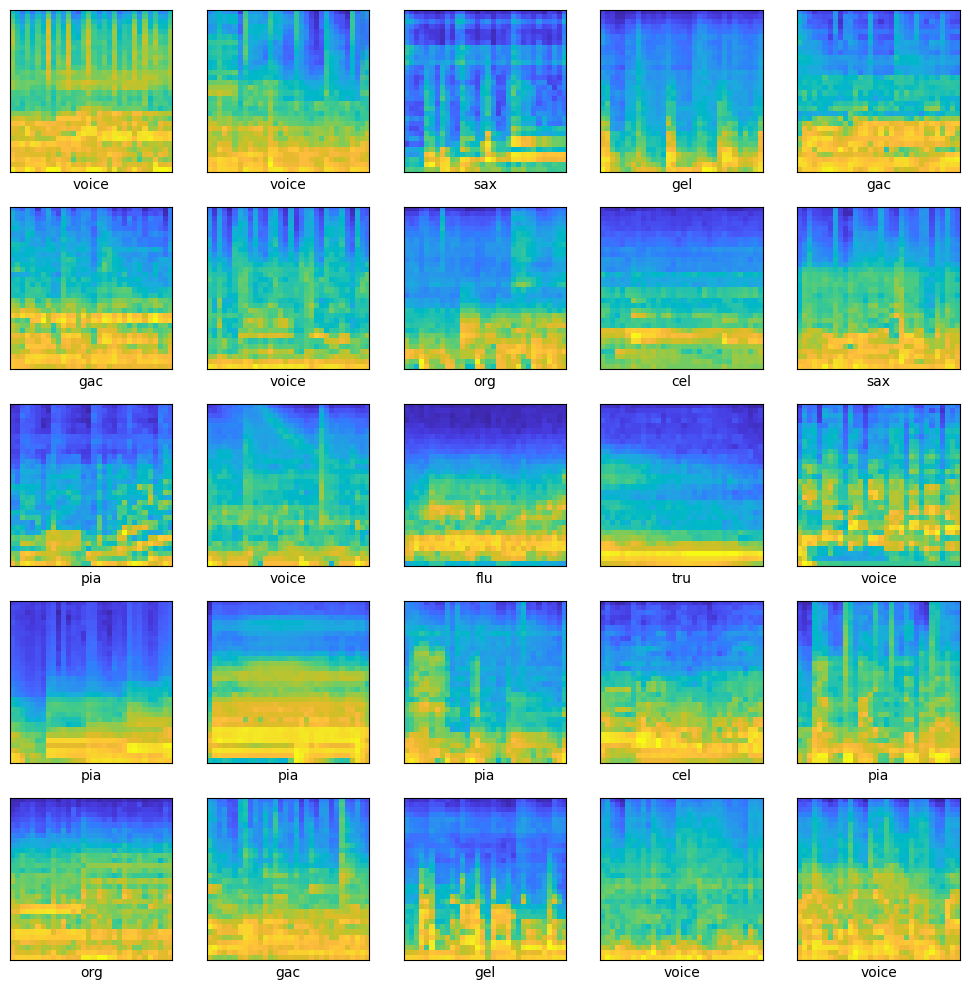

In [8]:
import matplotlib.pyplot as plt

class_names = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voice']

import random

random_indices = random.sample(range(len(train_images)), 25)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])
    plt.xlabel(class_names[train_labels[idx]])

plt.tight_layout()
plt.show()

In [9]:
print("building the convolution model...")

conv_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(32, 32, 3)),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(11, activation='softmax')
])

print("compiling the convolution model...")

conv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

print("conv model training...")

conv_hist = conv_model.fit(train_ds, epochs=35, validation_data=val_ds)



building the convolution model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


compiling the convolution model...
conv model training...
Epoch 1/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.2006 - loss: 3.5661 - val_accuracy: 0.0052 - val_loss: 21.1583
Epoch 2/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2560 - loss: 2.1227 - val_accuracy: 0.0062 - val_loss: 25.0360
Epoch 3/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2719 - loss: 2.0544 - val_accuracy: 0.0196 - val_loss: 19.2071
Epoch 4/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2851 - loss: 2.0296 - val_accuracy: 0.1818 - val_loss: 3.0471
Epoch 5/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3015 - loss: 2.0180 - val_accuracy: 0.2655 - val_loss: 2.2094
Epoch 6/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3183 - loss: 1.9753 - val_accuracy: 0.3192 - val_loss: 1.9934
Epoch 7/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3193 - loss: 1.9548 - val_accuracy: 0.3213 - val_loss: 1.9941
Epoch 8/35
121/121 ━━━━━━━━━━━━━━━━

In [10]:
conv_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,160,291 (61.65 MB)

 Trainable params: 5,386,251 (20.55 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 10,772,504 (41.09 MB)

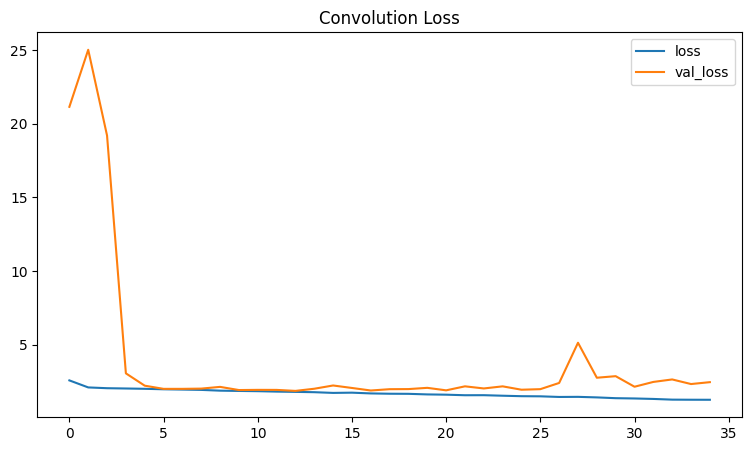

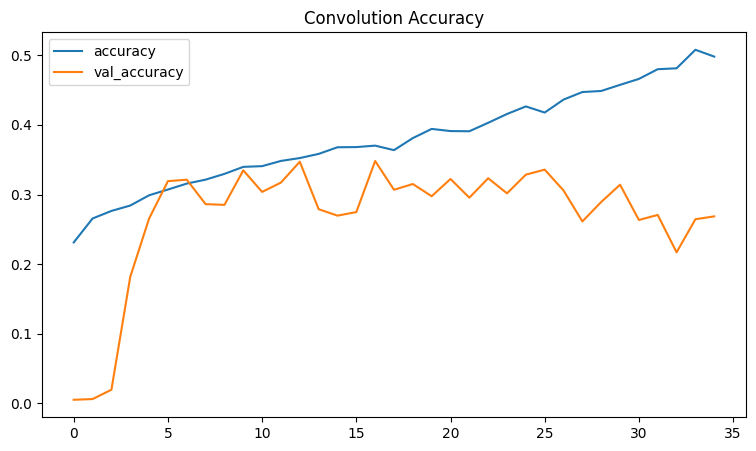

In [11]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_hist.history["loss"], label="loss")
plt.plot(conv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_hist.history["accuracy"], label="accuracy")
plt.plot(conv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.show()

In [12]:
import numpy as np

# Convolution model accuracy
conv_train_accuracy = np.array(conv_hist.history["accuracy"])
conv_val_accuracy = np.array(conv_hist.history["val_accuracy"])


# Print accuracy arrays
print("Convolution Training Accuracy:", conv_train_accuracy)
print("Convolution Validation Accuracy:", conv_val_accuracy)


Convolution Training Accuracy: [0.2312064  0.26556444 0.27641436 0.28416431 0.29888919 0.30715579
 0.31568071 0.32136399 0.32963058 0.3397055  0.34073883 0.34823042
 0.35236374 0.35830534 0.3678636  0.36812192 0.37018859 0.36373031
 0.38103849 0.39421338 0.3911134  0.39085507 0.40299663 0.41565487
 0.42650479 0.41772151 0.43632138 0.44717127 0.44872126 0.45750451
 0.46602944 0.47997934 0.481271   0.50787908 0.49806252]
Convolution Validation Accuracy: [0.00516529 0.00619835 0.0196281  0.18181819 0.26549587 0.31921488
 0.32128099 0.28615701 0.28512397 0.33471075 0.30371901 0.31714877
 0.34710744 0.27892563 0.26962811 0.27479339 0.34814051 0.30681819
 0.31508264 0.29752067 0.32231405 0.29545453 0.32334712 0.30165288
 0.3285124  0.33574381 0.30578512 0.26136363 0.28925619 0.3140496
 0.26342976 0.27066115 0.21694215 0.2644628  0.26859504]


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
from PIL import ImageFont, ImageDraw, Image
import glob

# Get list of directories, ensure the path is correct
listf = sorted(glob.glob("/content/drive/MyDrive/testset/*"))
print(listf)  # Print listf to verify its contents
L = 0
num_classes = 11

# Handle case where listf is empty
if not listf:
    print("Error: No directories found at the specified path.")
    sys.exit(1)  # Exit the script with an error code

# Initialize labels array with the correct size
labels = []  # Initialize as an empty list

# Restrict loop to actual number of folders found
for i in range(0, min(num_classes, len(listf))):
    listg = glob.glob(listf[i] + "/*png")
    L += len(listg)  # Update L with the number of images in each class
    # Append labels for the current class to the labels array
    # *** FIX: Use i directly instead of multiplying by len(listg) to get correct label for each image ***
    labels.extend([i] * len(listg))

s = [32, 32]
testData = np.full((L, s[0], s[1], 3), 1)
cnt = 0
F = []

for i in range(0, min(num_classes, len(listf))):  # Ensure i stays within bounds
    listg = sorted(glob.glob(listf[i] + "/*png"))
    for m in range(0, len(listg)):
        imgname = listg[m]
        image = cv2.imread(imgname)
        image = cv2.resize(image, (s[1], s[0]))
        testData[cnt, :, :, :] = image
        # Labels are already assigned, no need to reassign here
        # labels[cnt] = i
        cnt = cnt + 1

# Convert labels list to a NumPy array
labels = np.array(labels, dtype=int)

['/content/drive/MyDrive/testset/cello', '/content/drive/MyDrive/testset/cla', '/content/drive/MyDrive/testset/flu', '/content/drive/MyDrive/testset/gac', '/content/drive/MyDrive/testset/gel', '/content/drive/MyDrive/testset/org', '/content/drive/MyDrive/testset/pia', '/content/drive/MyDrive/testset/processed_data', '/content/drive/MyDrive/testset/sax', '/content/drive/MyDrive/testset/tru', '/content/drive/MyDrive/testset/vio', '/content/drive/MyDrive/testset/voice']


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

(1025, 32, 32, 3)
(1025,)
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
[ 0  0  0 ... 10 10 10]
[10  0  0 ...  0  0  0]
Test accuracy: 24.487805366516113
[[ 61   0   1   2   1   0   2   0   4   3]
 [ 22   0   0   1   0   0   2   0   0   0]
 [ 35   0  30   0   1   0   8   0   2   4]
 [140   0   4   4   8   0  11   0   3  26]
 [112   0   2  18   6   0   4   0   2  60]
 [ 33   0   1   1   3   0   4   0   0  13]
 [217   0   9   2   4   0  61   0   1  18]
 [  8   0   0   0   0   0   2   0   0   0]
 [ 10   0   0   0   0   0   0   0   0   4]
 [ 42   0   0   0   0   0   3   0   9   1]]
[0.82432432 0.         0.375      0.02040816 0.02941176 0.
 0.19551282 0.         0.         0.01818182]
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         cel       0.09      0.82      0.16        74
         cla       0.00      0.00      0.00        25
         flu       0.64      0.38      0.47        80
         gac       0.14      0.02      0.04       196
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


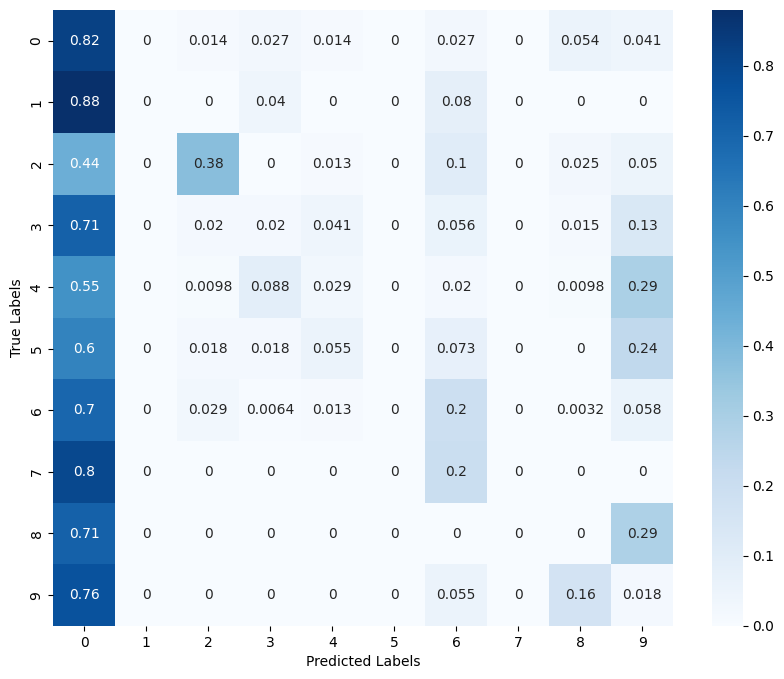

In [16]:
test_images = testData.astype('float32') / 255
# Reshape test_labels to be 1D
test_labels = labels.ravel()  # or labels.flatten()
print(test_images.shape)
print(test_labels.shape)
labels = conv_model.predict(test_images)
test_out = np.argmax(np.round(labels), axis=1)
print(test_labels)  # Print test_labels instead of testlabels
print(test_out)
test_loss, test_acc = conv_model.evaluate(test_images, test_labels, verbose=0)  # verbose=0 to suppress the progress bar
# print("Test loss: {0:.6f}, Test accuracy: {1:.6f}".format(test_loss,test_acc))
print('Test accuracy:', test_acc * 100)
cm = confusion_matrix(test_labels, test_out)  # Use test_labels instead of testlabels
print(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())
a = conv_model.predict(test_images)
# print(a)

# Get unique classes from test_labels and test_out
unique_classes = np.unique(np.concatenate((test_labels, test_out)))

# Update target_names based on unique classes
target_names = [class_names[i] for i in unique_classes]

# ... (rest of your code) ...

# Print classification report using updated target_names
print(classification_report(test_labels, test_out, target_names=target_names))

import pandas as pd

pd.DataFrame(a).to_csv("a.csv")
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()